# LambdaMART in Python

This is an implementation of LambdaMART in Python using sklearn and pandas. This is for educational purposes. 

But a secondary goal in getting this into Python is to more easily hack the algorithm to try new ideas. For example, this [blog article on two-sided marketplaces](https://opensourceconnections.com/blog/2017/07/04/optimizing-user-product-match-economies/), perhaps as more of an online algorithm (retiring old trees in the ensemble, adding new ones over time), perhaps with different model architectures in the ensemble (BERTy transformery things?) but all that preserve some of the nice things about LambdaMART (directly optimizing a list-wise metric)

This is adapted from [RankLib](https://github.com/o19s/RankyMcRankFace/blob/master/src/ciir/umass/edu/learning/tree/LambdaMART.java#L444) based on [this paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf) from Microsoft Research.

## Table of Contents

1. [Setup - TheMovieDB corpus and log Elasticsearch features from TMDB](#Part-Zero---Setup---Get-TheMovieDB-Corpus-and-Log-Simple-Features) - plumbing to interact with Elasticsearch Learning to Rank to log a few basic features for our exploration
2. [Pairwise swapping](#Part-One---Collect-pair-wise-DCG-diffs) - here we demonstrate the core operation of LambdaMART - pairwise swapping of pairs and examining DCG (or another ranking metric) impact
3. [Scale to learn errors, not just swaps](#Part-Two---Compute-the-swaps-but-scaled-to-current-model's-error) - here we show how LambdaMART isn't just about learning the pairwise DCG difference of a swap, but the error currently in the model at predicting the DCG impact of that swap
4. [Weigh predictions](#Part-Three---Weigh-each-leaf's-predictions) - here we weigh the predictions of the next model in the ensemble based on how much DCG remains to be learned. 
5. [Putting it all together](#Part-Four---Putting-it-all-together,-from-the-top!) - the full algorithm in one place. You can also compare this notebook's output and learning to Ranklib.

## Known Issues

I'm still learning the nooks and crannies of the algorithm. So there are some known issues as this is actively being developed.

1. **Likely bug** - When using DCG, the model here seems to wander around more than Ranklib, instead of converging. I think likely this points at an underlying bug that's actively being investigated.
2. **Performance** - a single training round takes about 9 seconds. There's room for improvement in the hot part of the loop (dcg computation and swapping)

## Part Zero - Setup - Get TheMovieDB Corpus and Log Simple Features

In this step we download TheMovieDB Corpus and log some featurs (title and overview BM25). At the end we have a simple dataframe

In [2]:
from ltr.client import ElasticClient
client = ElasticClient()

/Users/doug/ws/hello-ltr/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Download and index TMDB corpus and training set

Download [TheMovieDB](http://themoviedb.org) corpus and small toy training set with 40 queries labeled.

In [3]:
from ltr import download
corpus='http://es-learn-to-rank.labs.o19s.com/tmdb.json'
judgments='http://es-learn-to-rank.labs.o19s.com/title_judgments.txt'

download([corpus, judgments], dest='data/');
from ltr.index import rebuild
from ltr.helpers.movies import indexable_movies

movies=indexable_movies(movies='data/tmdb.json')
rebuild(client, index='tmdb', doc_src=movies)

data/tmdb.json already exists
data/title_judgments.txt already exists
Index tmdb already exists. Use `force = True` to delete and recreate


### Log two features - title & overview

Using the Elasticsearch Learning to Rank plugin, we:

1. Log two features: title and overview bm25
2. Create a pandas dataframe containing the labels and features

In [4]:
from ltr.log import FeatureLogger
from ltr.judgments import judgments_open
from itertools import groupby
from ltr.judgments import to_dataframe

client.reset_ltr(index='tmdb')

config = {"validation": {
              "index": "tmdb",
              "params": {
                  "keywords": "rambo"
              }
    
           },
           "featureset": {
            "features": [
                { #1
                    "name": "title_bm25",
                    "params": ["keywords"],
                    "template": {
                        "match": {"title": "{{keywords}}"}
                    }
                },
                { #2
                    "name": "overview_bm25",
                    "params": ["keywords"],
                    "template": {
                        "match": {"overview": "{{keywords}}"}
                    }
                }
            ]
    }}


client.create_featureset(index='tmdb', name='movies', ftr_config=config)

# Log features for each query
ftr_logger=FeatureLogger(client, index='tmdb', feature_set='movies')
with judgments_open('data/title_judgments.txt') as judgment_list:
    for qid, query_judgments in groupby(judgment_list, key=lambda j: j.qid):
        ftr_logger.log_for_qid(judgments=query_judgments, 
                               qid=qid,
                               keywords=judgment_list.keywords(qid))
        
# Convert to Pandas Dataframe
judgments = to_dataframe(ftr_logger.logged)

Removed Default LTR feature store [Status: 200]
Initialize Default LTR feature store [Status: 200]
Create movies feature set [Status: 201]
Recognizing 40 queries...


### Examine judgments dataframe

In the dataframe we have a set of (query, document, grade) that label how relevant a document (movie) is for each query.

* qid - 'query id' - a unique identifier for this query
* docId - an identifier for the document (here movie) being labeled
* grade - how relevant a movie is on a 0-4 scale
* keywords - the query keywords that go along with the query id
* features - the two features we logged, 0th is title_bm25, 1st is overview_bm25

In [5]:
judgments

,uid,qid,keywords,docId,grade,features
0,1_7555,1,rambo,7555,4,"[11.657399, 10.083591]"
1,1_1370,1,rambo,1370,3,"[9.456276, 13.265001]"
2,1_1369,1,rambo,1369,3,"[6.036743, 11.113943]"
3,1_13258,1,rambo,13258,2,"[0.0, 6.869545]"
4,1_1368,1,rambo,1368,4,"[0.0, 11.113943]"
...,...,...,...,...,...,...
1385,40_37079,40,star wars,37079,0,"[0.0, 0.0]"
1386,40_126757,40,star wars,126757,0,"[0.0, 0.0]"
1387,40_39797,40,star wars,39797,0,"[0.0, 0.0]"
1388,40_18112,40,star wars,18112,0,"[0.0, 0.0]"


## Part One - Collect pair-wise DCG diffs

The first-pass iteration of LambdaMART, for each query, we examine the DCG\* impact of swapping each result with another result in the listing.

\* replace DCG with your metric of interest: MAP, Precision@N, etc

In [6]:
from math import log, exp
import numpy as np 

def rank_with_swap(ranked_list, rank1=0, rank2=0):
    """ Set the display rank of positions given the provided swap """
    ranked_list['display_rank'] = ranked_list.index.to_series()
    
    if rank1 != rank2:
        ranked_list.loc[rank1, 'display_rank'] = rank2
        ranked_list.loc[rank2, 'display_rank'] = rank1
    return ranked_list
    

def dcg(ranked_list, at=10):
    """Given a list, compute DCG -- 
       uses same variant as lambdamart 2**grade / log2(displayrank)
    """
    ranked_list['discount'] = 1 / (1 + (np.log2(2 + ranked_list['display_rank'])))
    ranked_list['gain'] = (2**ranked_list['grade']) * ranked_list['discount'] # TODO - precompute gain on swapping
    return sum(ranked_list['gain'].head(at))

def compute_swaps(query_judgments, axis, metric=dcg, at=10):
    """Compute the 'lambda' the DCG impact of every query result swapped with every-other query result"""
    
    # Sort to see ideal ordering
    # This isn't strictly nescesarry, but it's helpful to understand the algorithm
    query_judgments = query_judgments.sort_values('grade', ascending=False).reset_index()

    # Instead of explicitly 'swapping' we just swap the 'display_rank' - where 
    # in the final ranking this would be placed. We can easily use that to compute DCG
    query_judgments['display_rank'] = query_judgments.index.to_series()
    query_judgments['dcg'] = metric(query_judgments, at=at)
    best_dcg = query_judgments.loc[0, 'dcg']

    query_judgments['lambda'] = 0.0
    
    # TODO - redo inner body as 
    for better in range(0,len(query_judgments)):
        for worse in range(better+1,len(query_judgments)):
            if better > at and worse > at:
                break

            if query_judgments.loc[better, 'grade'] > query_judgments.loc[worse, 'grade']:
                query_judgments = rank_with_swap(query_judgments, better, worse)
                query_judgments['dcg'] = metric(query_judgments, at=at)

                dcg_after_swap = query_judgments.loc[0, 'dcg']
                delta = abs(best_dcg - dcg_after_swap)

                if delta > 0.0:

                    # Add delta to better's lambda (-delta to worse's lambda)
                    query_judgments.loc[better, 'lambda'] += delta
                    query_judgments.loc[worse, 'lambda'] -= delta

    # print(query_judgments[['keywords', 'docId', 'grade', 'lambda', 'features']])
    return query_judgments

# For each query, compute lambdas
# %prun -s cumulative lambdas_per_query = judgments.groupby('qid').apply(compute_swaps, axis=1)
# judgments
lambdas_per_query = judgments.groupby('qid').apply(compute_swaps, axis=1)
lambdas_per_query

index        uid  qid   keywords   docId  grade  \
qid                                                       
1   0       0     1_7555    1      rambo    7555      4   
    1       4     1_1368    1      rambo    1368      4   
    2       2     1_1369    1      rambo    1369      3   
    3       1     1_1370    1      rambo    1370      3   
    4       3    1_13258    1      rambo   13258      2   
...       ...        ...  ...        ...     ...    ...   
40  25   1371   40_81899   40  star wars   81899      0   
    26   1370  40_209276   40  star wars  209276      0   
    27   1368   40_52959   40  star wars   52959      0   
    28   1367   40_85783   40  star wars   85783      0   
    29   1389   40_43052   40  star wars   43052      0   

                      features  display_rank  discount      gain        dcg  \
qid                                                                           
1   0   [11.657399, 10.083591]             0  0.500000  8.000000  22.796491   
    1         [0.0, 11.113943]             1  0.386853  6.189645  22.796491   
    2    [6.036743, 11.113943]             2  0.333333  2.666667  22.796491   
    3    [9.456276, 13.265001]             3  0.301030  2.408240  22.796491   
    4          [0.0, 6.869545]             4  0.278943  1.115772  22.796491   
...                        ...           ...       ...       ...        ...   
40  25         [0.0, 6.868508]            25  0.173765  0.173765  21.491637   
    26        [5.8994045, 0.0]            26  0.172195  0.172195  21.491637   
    27           [7.2726, 0.0]            27  0.170707  0.170707  21.491637   
    28           [7.2726, 0.0]            28  0.169294  0.169294  21.491637   
    29              [0.0, 0.0]             8  0.231378  0.231378  21.491637   

            lambda  
qid                 
1   0   183.343798  
    1   116.134366  
    2    39.713833  
    3    30.087439  
    4     8.628473  
...            ...  
40  25  -10.968332  
    26  -11.062526  
    27  -11.151815  
    28  -11.236624  
    29  -11.317325  

[1390 rows x 12 columns]

### Look at Precision instead of DCG

We can really use any ranking metric to achieve goals important to our product. This includes potentially ones we invent or come up with ourselves!

In [7]:
def precision(ranked_list, max_grade=4.0, at=10):
    """Given a list, compute simple precision. Really this is cumalitive gain."""
    above_n = ranked_list[ranked_list['display_rank'] < at]
    
    if (max_grade * at) == 0.0:
        print("0")
        return 0.0
    
    return float(sum(above_n['grade'])) / (max_grade * at)


lambdas_per_query_prec = judgments.groupby('qid').apply(compute_swaps, axis=1, metric=precision)
lambdas_per_query_prec.loc[5, :]

,index,uid,qid,keywords,docId,grade,features,display_rank,dcg,lambda
0,149,5_603,5,matrix,603,4,"[11.657399, 10.040129]",0,0.3,2.300
1,151,5_605,5,matrix,605,3,"[9.456276, 0.0]",1,0.3,1.725
2,150,5_604,5,matrix,604,3,"[9.456276, 9.392262]",2,0.3,1.725
3,152,5_55931,5,matrix,55931,2,"[0.0, 10.798681]",3,0.3,1.150
4,172,5_73262,5,matrix,73262,1,"[0.0, 0.0]",32,0.3,0.575
5,174,5_33068,5,matrix,33068,0,"[0.0, 0.0]",5,0.3,0.000
6,169,5_3573,5,matrix,3573,0,"[0.0, 0.0]",6,0.3,0.000
7,170,5_12254,5,matrix,12254,0,"[0.0, 0.0]",7,0.3,0.000
8,171,5_17813,5,matrix,17813,0,"[0.0, 0.0]",8,0.3,0.000
9,173,5_17960,5,matrix,17960,0,"[0.0, 0.0]",9,0.3,0.000


### Fit a model on the lambdas

The core operation is fitting an operation on the lambdas (the accumulated pairwise differences)

In [8]:
train_set = lambdas_per_query[['lambda', 'features']]
train_set

lambda                features
qid                                       
1   0   183.343798  [11.657399, 10.083591]
    1   116.134366        [0.0, 11.113943]
    2    39.713833   [6.036743, 11.113943]
    3    30.087439   [9.456276, 13.265001]
    4     8.628473         [0.0, 6.869545]
...            ...                     ...
40  25  -10.968332         [0.0, 6.868508]
    26  -11.062526        [5.8994045, 0.0]
    27  -11.151815           [7.2726, 0.0]
    28  -11.236624           [7.2726, 0.0]
    29  -11.317325              [0.0, 0.0]

[1390 rows x 2 columns]

In [9]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree = DecisionTreeRegressor()
tree.fit(train_set['features'].tolist(), train_set['lambda'])

DecisionTreeRegressor()

### DCG-based Lambda Predictions

We show predicting some known examples. In the first case, strong title and overview scores. In the second case, no title or overview scores

In [10]:
tree.predict([[11.6, 10.08]])

array([183.34379848])

In [11]:
tree.predict([[0.0, 0.0]])

array([-6.80365819])

It's more typical we would restrict the complexity of each tree in the ensemble. We can dump the tree see [understanding sklearn's tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)

In [12]:
tree = DecisionTreeRegressor(max_leaf_nodes=4)
tree.fit(train_set['features'].tolist(), train_set['lambda'])
plot_tree(tree)

[Text(248.0, 308.0, 'X[0] <= 10.666\nmse = 793.283\nsamples = 1390\nvalue = 0.0'),
 Text(124.0, 184.79999999999998, 'X[0] <= 9.182\nmse = 222.998\nsamples = 1329\nvalue = -4.264'),
 Text(62.0, 61.599999999999966, 'mse = 107.23\nsamples = 1301\nvalue = -5.173'),
 Text(186.0, 61.599999999999966, 'mse = 3778.904\nsamples = 28\nvalue = 37.982'),
 Text(372.0, 184.79999999999998, 'X[0] <= 13.782\nmse = 4190.964\nsamples = 61\nvalue = 92.903'),
 Text(310.0, 61.599999999999966, 'mse = 4938.44\nsamples = 34\nvalue = 72.93'),
 Text(434.0, 61.599999999999966, 'mse = 2114.76\nsamples = 27\nvalue = 118.054')]

## Part Two - Compute the swaps but _scaled_ to current model's error

LambdaMART is an _ensemble_ model. It's not just about the first model, but collecting a series of models where each model makes a gradual improvement on the current model. The technique used is known as [Gradient Boosting]()

To build a model that compensates for the current model's error, we scale the next set of dependent vars to predict based on the correctness of the existing model in ranking. In this way, we eliminate where the model currently does a good job (no need to learn these) and leave in places where the model isn't doing a good job (this is where. we want ot learn)

In [15]:
learning_rate = 0.1
judgments['last_prediction'] = tree.predict(judgments['features'].tolist()) * learning_rate

def compute_swaps_scaled(query_judgments, axis, metric=dcg, at=10):
    """Compute the 'lambda' the DCG impact of every query result swapped with every-other query result
    
    
    """
    
    query_judgments = query_judgments.sort_values('last_prediction', ascending=False).reset_index()

    # Instead of explicitly 'swapping' we just swap the 'display_rank' - where 
    # in the final ranking this would be placed. We can easily use that to compute DCG
    query_judgments['display_rank'] = query_judgments.index.to_series()
    query_judgments['dcg'] = metric(query_judgments, at=at)
    best_dcg = query_judgments.loc[0, 'dcg']

    query_judgments['lambda'] = 0.0
    query_judgments['delta'] = 0.0
    
    for better in range(0,len(query_judgments)):
        for worse in range(better+1,len(query_judgments)):
            if better > at and worse > at:
                break
            if query_judgments.loc[better, 'grade'] > query_judgments.loc[worse, 'grade']:
                swap_judgments = rank_with_swap(query_judgments, better, worse)
                dcg_after_swap = metric(swap_judgments, at=at)

                delta = abs(best_dcg - dcg_after_swap)

                if delta > 0.0:
                    
                    # --------------
                    # NEW!
                    model_score_diff = query_judgments.loc[better, 'last_prediction'] - query_judgments.loc[worse, 'last_prediction']
                    rho = 1.0 / (1.0 + exp(model_score_diff))    
                    # --------------
                    # rho works as follows
                    # 
                    # model ranks                    rho
                    # better higher than worse       approaches 0      <-- model currently doing well!
                    # better same as worse.          0.5  
                    # worse higher than better       approaches 1      <-- model currently doing poorly!
                    # 
                    query_judgments.loc[better, 'delta'] += delta
                    
                    # Use rho to scale the lambdas
                    query_judgments.loc[better, 'lambda'] += delta * rho
        
                    query_judgments.loc[worse, 'lambda'] -= delta * rho
                    query_judgments.loc[worse, 'delta'] -= delta

    return query_judgments

judgments = to_dataframe(ftr_logger.logged)
judgments['last_prediction'] = 0.0
lambdas_per_query = judgments.groupby('qid').apply(compute_swaps_scaled, axis=1)
#
lambdas_per_query

index        uid  qid   keywords   docId  grade  \
qid                                                       
1   0       0     1_7555    1      rambo    7555      4   
    1      21   1_223195    1      rambo  223195      0   
    2      23    1_22777    1      rambo   22777      0   
    3      24    1_43189    1      rambo   43189      0   
    4      25      1_318    1      rambo     318      0   
...       ...        ...  ...        ...     ...    ...   
40  25   1365    40_1892   40  star wars    1892      3   
    26   1364    40_1895   40  star wars    1895      2   
    27   1363  40_330459   40  star wars  330459      3   
    28   1362   40_12180   40  star wars   12180      2   
    29   1389   40_43052   40  star wars   43052      0   

                      features  last_prediction  display_rank  discount  \
qid                                                                       
1   0   [11.657399, 10.083591]              0.0             0  0.500000   
    1               [0.0, 0.0]              0.0             1  0.386853   
    2               [0.0, 0.0]              0.0             2  0.333333   
    3               [0.0, 0.0]              0.0             3  0.301030   
    4               [0.0, 0.0]              0.0             4  0.278943   
...                        ...              ...           ...       ...   
40  25        [0.0, 2.4547963]              0.0            25  0.173765   
    26    [6.487482, 2.062405]              0.0            26  0.172195   
    27   [7.2694716, 4.237955]              0.0            27  0.170707   
    28  [10.194733, 6.8944135]              0.0            28  0.169294   
    29              [0.0, 0.0]              0.0            10  0.218104   

            gain        dcg     lambda       delta  
qid                                                 
1   0   8.000000  11.453678  91.640615  183.281230  
    1   0.386853  11.453678  -0.848604   -1.697208  
    2   0.333333  11.453678  -1.250000   -2.500000  
    3   0.301030  11.453678  -1.492275   -2.984550  
    4   0.278943  11.453678  -1.657928   -3.315856  
...          ...        ...        ...         ...  
40  25  1.390123  13.216213  -2.609877   -5.219755  
    26  0.688782  13.216213  -3.481066   -6.962132  
    27  1.365658  13.216213  -2.634342   -5.268684  
    28  0.677175  13.216213  -3.515886   -7.031771  
    29  0.218104  13.216213  -3.532026   -7.064052  

[1390 rows x 14 columns]

Zero in on 2 swapped by each result worse than it in query `ramba`

```
better_grade worse_grade, model_score_diffs, rho,                 dcg_delta
2 1                       0.758706128029972  0.31892724571177816  0.02502724555344038
2 1                       0.981162516523929  0.2726611758805124   0.04377062727053094
2 0                       1.142439045359345  0.24187283082372052  0.11698017724693699
2 0                       1.142439045359345  0.24187283082372052  0.14090604137532914
2 1                       1.142439045359345  0.24187283082372052  0.08043118677314176
2 1                       1.142439045359345  0.24187283082372052  0.17784892734690594
2 1                       1.142439045359345  0.24187283082372052  0.19254512210920538
2 1                       1.142439045359345  0.24187283082372052  0.20543079947538878
2 1                       1.142439045359345  0.24187283082372052  0.21685570619866112
2 0                       1.142439045359345  0.24187283082372052  0.22708156316293504
2 0                       1.142439045359345  0.24187283082372052  0.23630863576764227
2 0                       1.142439045359345  0.24187283082372052  0.24469312448475122
2 0                       1.142439045359345  0.24187283082372052  0.2523588995024131
2 0                       1.142439045359345  0.24187283082372052  0.25940563061320177
2 0                       1.142439045359345  0.24187283082372052  0.2659145510893115
...
2 0                       1.142439045359345  0.24187283082372052 0.34214193097965406
```

Summing all the model score diffs, we see those are rather high. This results in a high-ish rho between (for each value here 0.25-0.31). So each dcg_delta is added to the model.

What's the intuition here? The model hasn't entirely nailed this example, the model feels there's more 'dcg_delta' to learn to push it away from those less relevant results.

### Zooming out to more of `rambo`

We see a similar pattern in results with mediocre grades (2 and 3) where the resulting rho-scaled lambda's are higher than you might expect. The model's happy with the position of 0, but the ranking of other results could be separated more. The model diff should be higher when compared to the dcg diff to push the middling results away from the irrelevant result.

So the next tree learns these lambdas using the resulting features moreso than other results.

In [16]:
lambdas_per_query.loc[1, :][['keywords', 'display_rank',  'grade', 'last_prediction', 'delta', 'lambda', 'features']].sort_values('last_prediction', ascending=False)

,keywords,display_rank,grade,last_prediction,delta,lambda,features
0,rambo,0,4,0.0,183.281230,91.640615,"[11.657399, 10.083591]"
21,rambo,21,3,0.0,-5.103318,-2.551659,"[9.456276, 13.265001]"
23,rambo,23,3,0.0,-5.165059,-2.582529,"[6.036743, 11.113943]"
24,rambo,24,2,0.0,-5.193199,-2.596599,"[0.0, 6.869545]"
25,rambo,25,4,0.0,0.000000,0.000000,"[0.0, 11.113943]"
26,rambo,26,1,0.0,-5.244873,-2.622437,"[0.0, 7.8627386]"
27,rambo,27,1,0.0,-5.268684,-2.634342,"[0.0, 4.563677]"
28,rambo,28,0,0.0,-5.827818,-2.913909,"[0.0, 0.0]"
29,rambo,29,0,0.0,-5.860098,-2.930049,"[0.0, 0.0]"
30,rambo,30,0,0.0,-5.890869,-2.945435,"[0.0, 0.0]"


In [17]:
from sklearn.tree import DecisionTreeRegressor

train_set = lambdas_per_query[['lambda', 'features']]
train_set

tree2 = DecisionTreeRegressor()
tree2.fit(train_set['features'].tolist(), train_set['lambda'])

DecisionTreeRegressor()

### More 'oomph' in second tree for the last tree's error cases

We see in the following lambdas our next tree learns more about the areas the last model seemed to need correction. 

The first example is well covered by the first tree.

In [18]:
tree2.predict([[11.6, 10.08]])

array([91.64061509])

The second example reflects some of the middling ranked results

In [19]:
tree2.predict([[0.0, 6.869545]])

array([-2.59659949])

## Part Three - Weigh each leaf's predictions

Because we're dealing with trees, each leaf corresponds to a set of examples that have been grouped to this node. In addition to per-swap 'rho' we also care about a per-swap 'weight', referred to in gradient boosting as 'gamma'. 

Gamma means picking a weight for this sub-model that best predicts the final function.

First we group by the paths in the tree to uniquely identify each leaf

In [21]:
def compute_swaps_scaled_with_weights(query_judgments, axis, metric=dcg, at=10):
    """Compute the 'lambda' the DCG impact of every query result swapped with every-other query result
    
    
    """
    
    # Sort to see ideal ordering
    # This isn't strictly nescesarry, but it's helpful to understand the algorithm
    query_judgments = query_judgments.sort_values('last_prediction', ascending=False).reset_index()

    # Instead of explicitly 'swapping' we just swap the 'display_rank' - where 
    # in the final ranking this would be placed. We can easily use that to compute DCG
    query_judgments['display_rank'] = query_judgments.index.to_series()
    query_judgments['train_dcg'] = query_judgments['dcg'] = metric(query_judgments, at=at)
    train_dcg = query_judgments.loc[0, 'dcg']

    query_judgments['lambda'] = 0.0
    query_judgments['weight'] = 0.0
    
    for better in range(0,len(query_judgments)):
        for worse in range(better+1,len(query_judgments)):
            if better > at and worse > at:
                break
                
            if query_judgments.loc[better, 'grade'] > query_judgments.loc[worse, 'grade']:
                query_judgments = rank_with_swap(query_judgments, better, worse)
                query_judgments['dcg'] = metric(query_judgments, at=at)

                dcg_after_swap = query_judgments.loc[0, 'dcg']
                delta = abs(train_dcg - dcg_after_swap)

                if delta > 0.0:
                    last_model_score_diff = query_judgments.loc[better, 'last_prediction'] - query_judgments.loc[worse, 'last_prediction']
                    rho = 1.0 / (1.0 + exp(last_model_score_diff))   

                    assert(delta >= 0.0)
                    assert(rho >= 0.0)
                   
                    query_judgments.loc[better, 'lambda'] += delta * rho
                    query_judgments.loc[worse, 'lambda'] -= delta * rho
            
                    # --------------
                    # NEW!
                    #  last_model_score_diff        rho         weight
                    #      0.0                      0.5         0.25 (max possible value)
                    #      100.0                    0.0000      0.0  (max possible value)
                    # 
                    # If the current model has an ambiguous prediction, we include more of the delta in the weight
                    # If the current model has a strong prediction, weight approaches 0
                    query_judgments.loc[better, 'weight'] += rho * (1.0 - rho) * delta;
                    query_judgments.loc[worse, 'weight'] += rho * (1.0 - rho) * delta;
                    #
                    # These will be used to rescale each decision tree node's predictions
                    # If many results in a leaf node have last model score ~ ambiguous
                    #     the resulting model will have a high denominator ~ (1 / deltaDCG)
                    # If many results in a leaf node have last model score - not ambiguous, positive
                    #     the resulting model will have a low denominator
                    #
                    # Apparently we want to cancel out the deltas if last model was ambiguous?
                    # ---------------

                    

    return query_judgments

# Convert to Pandas Dataframe
judgments = to_dataframe(ftr_logger.logged)
judgments['last_prediction'] = 0
lambdas_per_query = judgments.groupby('qid').apply(compute_swaps_scaled_with_weights, axis=1)

lambdas_per_query

NameError: name 'math' is not defined

In [ ]:
from sklearn.tree import DecisionTreeRegressor

train_set = lambdas_per_query[['lambda', 'features']]
train_set

tree3 = DecisionTreeRegressor(max_leaf_nodes=4)
tree3.fit(train_set['features'].tolist(), train_set['lambda'])
        

### Label each row with its unique prediction (ie tree path)

In [542]:
def tree_paths(tree, X):
    paths_as_array = tree.decision_path(X).toarray()
    paths = ["".join(item) for item in paths_as_array.astype(str)]
    return paths

lambdas_per_query['path'] = tree_paths(tree3, features)

### Override outputs using our own weighted average

The typical decision tree uses either the [median or mean of the target values](https://scikit-learn.org/stable/modules/tree.html#regression-criteria) classified to a given leaf node as the prediction. However, in the case of lambdaMART, we want to use a weighted average that accounts for how much of the DCG error out there has been accounted for. Thus the psuedoresponses are summed and divided by the remaining error DCG.

rho=0, then an example is weighed by `1/0.25*deltaNDCG` as there's a lot of outstanding DCG error left.

In [543]:
lambdas_per_query.groupby('path')['weight'].sum()

path
1010101     41.871274
1010110     17.304968
1011000     39.105907
1100000    129.959528
Name: weight, dtype: float64

In [544]:
lambdas_per_query.groupby('path')['lambda'].sum()

path
1010101     50.899615
1010110     34.429523
1011000     78.211815
1100000   -163.540952
Name: lambda, dtype: float64

In [545]:
round_predictions = lambdas_per_query.groupby('path')['lambda'].sum() / lambdas_per_query.groupby('path')['weight'].sum()
round_predictions.to_dict()

{'1010101': 1.2156213554683677,
 '1010110': 1.989574489468554,
 '1011000': 2.0,
 '1100000': -1.25839909859753}

[Text(111.60000000000001, 190.26, 'X[0] <= 8.205\nmse = 5.779\nsamples = 1390\nvalue = -0.0'),
 Text(55.800000000000004, 135.9, 'mse = 0.912\nsamples = 1246\nvalue = -0.101'),
 Text(167.4, 135.9, 'X[0] <= 8.242\nmse = 47.043\nsamples = 144\nvalue = 0.873'),
 Text(111.60000000000001, 81.53999999999999, 'mse = 0.0\nsamples = 1\nvalue = 78.212'),
 Text(223.20000000000002, 81.53999999999999, 'X[0] <= 8.4\nmse = 5.252\nsamples = 143\nvalue = 0.332'),
 Text(167.4, 27.180000000000007, 'mse = 53.276\nsamples = 12\nvalue = 2.199'),
 Text(279.0, 27.180000000000007, 'mse = 0.504\nsamples = 131\nvalue = 0.161')]

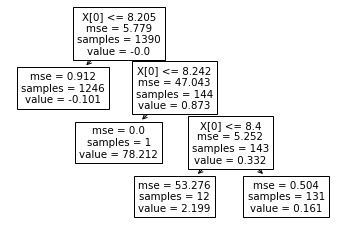

In [546]:
plot_tree(tree3)

### Wrap the original tree, and provide new value

Instead of directly using the provided decision tree, we want to use our prediction for each leaf. This `OverridenDecisionTree` takes the original tree, looks up the prediction path in the original tree, but uses our values for the predicted variable instead of what's here.

In [547]:
class OverridenRegressionTree:
    def __init__(self, predictions, tree):
        self.predictions = predictions
        self.tree = tree
        
    def predict(self, X):
        path = self.tree.decision_path(X).toarray().astype(str)
        path = "".join(path[0])
        
        paths_as_array = self.tree.decision_path(X).toarray()
        paths = ["".join(item) for item in paths_as_array.astype(str)]
        
        predictions = self.predictions[paths]
        
        # Any NaN predictions is a red flag, debug
        if np.any(predictions.isnull()):
            print(predictions[predictions.isnull()])
            print(pd.DataFrame(X)[predictions.isnull().reset_index(drop=True)])
            raise AssertionError("No prediction should be NaN")
        return np.array(self.predictions[paths].tolist())
        
override_tree = OverridenRegressionTree(predictions = round_predictions, tree=tree3)
override_tree.predict([[0.0, 6.869545], [10.0, 10.0]])

array([-1.2583991 ,  1.21562136])

## Part Four - Putting it all together, from the top!

Now we can put together the full lambdamart algorithm that 

1. Uses pair-wise swaps on our our metric (ie DCG) to generate decision tree predictors (the 'lambdas')
2. Focuses in on predicting where current model makes the wrong call when ranking by DCG
3. Predicts using a weighted average, weighed by 1 / (remaining DCG)

TODOs / known issues
* Why is DCG performance so different from Ranklib, and it seems to wander around more (precision does this)
* Speeding up the inner loop of the `compute_swaps_scaled_with_weights` that must run for ever query's swaps

In [548]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

def predict(ensemble, X, learning_rate=0.1):
    prediction = 0
    for tree in ensemble:
        prediction += tree.predict(X) * learning_rate
    return prediction.rename('prediction')


def tree_paths(tree, X):
    paths_as_array = tree.decision_path(X).toarray()
    paths = ["".join(item) for item in paths_as_array.astype(str)]
    return paths

ensemble=[]
def lambda_mart(judgments, rounds=20, learning_rate=0.1, max_leaf_nodes=8, metric=dcg):

    print(judgments.columns)
    # Convert to Pandas Dataframe
    lambdas_per_query = judgments.copy()


    lambdas_per_query['last_prediction'] = 0.0

    for i in range(0, rounds):
        print(f"round {i}")

        # ------------------
        #1. Build pair-wise predictors for this round
        lambdas_per_query = lambdas_per_query.groupby('qid').apply(compute_swaps_scaled_with_weights, 
                                                                   axis=1, metric=dcg)

        # ------------------
        #2. Train a regression tree on this round's lambdas
        features = lambdas_per_query['features'].tolist()
        tree = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes)
        tree.fit(features, lambdas_per_query['lambda'])    

        # ------------------
        #3. Reweight based on LambdaMART's weighted average
        # Add each tree's paths
        lambdas_per_query['path'] = tree_paths(tree, features)
        predictions = lambdas_per_query.groupby('path')['lambda'].sum() / lambdas_per_query.groupby('path')['weight'].sum()
        predictions = predictions.fillna(0.0) # for divide by 0

        # -------------------
        #4. Add to ensemble, recreate last prediction
        new_tree = OverridenRegressionTree(predictions=predictions, tree=tree)
        ensemble.append(new_tree)
        next_predictions = new_tree.predict(features)
        lambdas_per_query['last_prediction'] += (next_predictions * learning_rate) 
        
        print("Train DCGs")
        print("mean   ", lambdas_per_query['train_dcg'].mean())
        print("median ", lambdas_per_query['train_dcg'].median())
        print("----------")

        
        # Reset the dataframe for further processing

        lambdas_per_query = lambdas_per_query.drop('qid', axis=1).reset_index().drop(['level_1', 'index'], axis=1)

judgments = to_dataframe(ftr_logger.logged)
lambdas_per_query = lambda_mart(judgments=judgments, rounds=10, max_leaf_nodes=10, metric=dcg)

Index(['uid', 'qid', 'keywords', 'docId', 'grade', 'features'], dtype='object')
round 0
Train DCGs
mean    10.61593108150268
median  10.739621334025406
----------
round 1
Train DCGs
mean    14.34966497096901
median  13.216212771507438
----------
round 2
Train DCGs
mean    12.357610149958038
median  11.567827400752915
----------
round 3
Train DCGs
mean    14.24721713178369
median  13.016486241731291
----------
round 4
Train DCGs
mean    13.441858214366144
median  12.506165082920402
----------
round 5
Train DCGs
mean    14.091782646778626
median  13.016486241731291
----------
round 6
Train DCGs
mean    13.426222703083178
median  12.460843740423556
----------
round 7
Train DCGs
mean    14.008223263605812
median  13.016486241731291
----------
round 8
Train DCGs
mean    13.434549080998451
median  12.346789866126002
----------
round 9
Train DCGs
mean    13.862740868310802
median  12.615453090513515
----------


In [549]:
lambdas_per_query.iloc[282]

AttributeError: 'NoneType' object has no attribute 'iloc'

In [ ]:
ensemble[0].predictions

In [ ]:
plot_tree(ensemble[0].tree)

## Compare to ranklib output

In [ ]:
from ltr.ranklib import train
trainLog  = train(client,
                  training_set=ftr_logger.logged,
                  index='tmdb',
                  trees=10,
                  featureSet='movies',
                  modelName='title')

print("Every N rounds of ranklib")
trainLog.trainingLogs[0].rounds

## Examine queries we learned

Try out some queries, look at the final model prediction `last_prediction` compare to the correct ordering `grade`.

In [ ]:
lambdas_per_query[lambdas_per_query['qid'] == 2]